In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import scipy.special
from sklearn.linear_model import LassoCV, LogisticRegressionCV, LinearRegression, Lasso, LogisticRegression
from sklearn.base import clone
import joblib
from statsmodels.api import OLS
from sklearn.model_selection import StratifiedKFold
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_predict
import pandas as pd
import math
import shap
import joblib

In [3]:
from automl import reg_fn_gen, model_y_fn_gen, model_t_fn_gen

In [4]:
use_flaml = True
semi_synth = False
simple_synth = False
max_depth = 3
stack = False
n_splits = 5
data = 'welfare'
plot = True
scale = .5

In [5]:
if use_flaml:
    from myflaml import auto_reg, auto_clf, auto_weighted_reg

In [6]:
# The moment function, whose average we want to estimate: E[m(X; g)]
def moment_fn(x, test_fn):
    t1 = np.hstack([np.ones((x.shape[0], 1)), x[:, 1:]])
    t0 = np.hstack([np.zeros((x.shape[0], 1)), x[:, 1:]])
    return test_fn(t1) - test_fn(t0)

In [7]:
def pehe(cate, preds):
    return np.sqrt(np.mean((cate - preds)**2))

In [8]:
# Data loading and manipulation

if data == '401k':
    abtest = False
    def get_data(q=1, synthetic=False, random_seed=123, true_f=None, gen_epsilon=None):
        dfx = pd.read_csv('./401k/401k-x.csv', sep=',')
        dfy = pd.read_csv('./401k/401k-y.csv', sep=',')
        dfd = pd.read_csv('./401k/401k-d.csv', sep=',')
        dfx = dfx.drop(['db'], axis=1) # highly predictable from income
        X = np.hstack([dfd.values, dfx.values])
        column_names = ['treatment'] + list(dfx.columns)
        y = dfy.values.flatten() # outcome to numpy array

        mask = (dfx['inc'] > 0) & (dfx['inc'] >= np.percentile(dfx['inc'], 1))
        mask &= (dfx['inc'] <= np.percentile(dfx['inc'], 99))
        X = X[mask]
        y = y[mask]
        inds = np.arange(X.shape[0])
        np.random.shuffle(inds)
        X, y = X[inds], y[inds]

        if synthetic: # impute synthetic outcome based on known relationship  
            y = true_f(X) + gen_epsilon(X.shape[0])
            print(np.mean(moment_fn(X, true_f)))

        return X, y, [1, 2, 3, 4], column_names
elif data == 'criteo':
    abtest = True
    def get_data():
        df = pd.read_csv('./criteo-uplift-v2.1.csv')
        y = df['visit'].values
        T = df[['treatment']].values
        df = df.drop(['treatment', 'conversion', 'visit', 'exposure'], axis=1)
        column_names = ['treatment'] + list(df.columns)
        X = np.hstack([T, df.values])
        return X, y, np.arange(1, X.shape[1]), column_names
elif data == 'welfare':
    abtest = True
    def get_data():
        df = pd.read_csv('./welfarenolabel3.csv', na_values=-999)
        continuous = ['hrs1', 'income', 'rincome', 'age', 'polviews',
                      'educ', 'earnrs', 'sibs', 'childs', 'occ80', 'prestg80', 'indus80',
                      'res16', 'reg16', 'family16', 'parborn', 'maeduc', 'degree', 
                      'hompop', 'babies', 'preteen', 'teens', 'adults']
        categorical = ['partyid', 'wrkstat', 'wrkslf', 'marital', 'race', 'mobile16', 'sex', 'born']
        df = df[['y', 'w'] + continuous + categorical]
        df = df.dropna()
        df = df[~((df['polviews']>4) & (df['polviews'] < 5))]
        df = pd.get_dummies(df, columns=categorical, drop_first=True)
        display(df.describe())
        y = df['y'].values
        T = df[['w']].values
        df = df.drop(['y', 'w'], axis=1)
        column_names = ['treatment'] + list(df.columns)
        X = np.hstack([T, df.values])
        return X, y, np.arange(1, len(continuous) + 1), column_names

In [9]:
def true_f(X):
    return np.zeros(X.shape[0])

X, y, num_cols, column_names = get_data()
feat_ind = 2
column_names

,y,w,hrs1,income,rincome,age,polviews,educ,earnrs,sibs,...,marital_2.0,marital_3.0,marital_4.0,marital_5.0,race_2,race_3,mobile16_2.0,mobile16_3.0,sex_2,born_2.0
count,12907.000000,12907.000000,12907.000000,12907.000000,12907.000000,12907.000000,12907.000000,12907.000000,12907.000000,12907.000000,...,12907.000000,12907.000000,12907.000000,12907.000000,12907.000000,12907.000000,12907.000000,12907.000000,12907.000000,12907.000000
mean,0.290850,0.513287,42.260324,11.305183,10.223367,40.573952,4.083443,14.026497,1.745177,3.426823,...,0.028512,0.164484,0.033083,0.245913,0.116526,0.063841,0.272178,0.337181,0.496242,0.087549
std,0.454172,0.499843,14.018162,1.635527,2.744435,12.179377,1.376485,2.722665,0.830837,2.918114,...,0.166436,0.370729,0.178860,0.430644,0.320867,0.244480,0.445098,0.472766,0.500005,0.282649
min,0.000000,0.000000,0.000000,1.000000,1.000000,18.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,38.000000,12.000000,9.000000,31.000000,3.000000,12.000000,1.000000,2.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,1.000000,40.000000,12.000000,12.000000,40.000000,4.000000,14.000000,2.000000,3.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,50.000000,12.000000,12.000000,49.000000,5.000000,16.000000,2.000000,4.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000
max,1.000000,1.000000,89.000000,12.000000,12.000000,88.000000,7.000000,20.000000,8.000000,37.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


['treatment',
 'hrs1',
 'income',
 'rincome',
 'age',
 'polviews',
 'educ',
 'earnrs',
 'sibs',
 'childs',
 'occ80',
 'prestg80',
 'indus80',
 'res16',
 'reg16',
 'family16',
 'parborn',
 'maeduc',
 'degree',
 'hompop',
 'babies',
 'preteen',
 'teens',
 'adults',
 'partyid_1.0',
 'partyid_2.0',
 'partyid_3.0',
 'partyid_4.0',
 'partyid_5.0',
 'partyid_6.0',
 'partyid_7.0',
 'wrkstat_2.0',
 'wrkslf_2.0',
 'marital_2.0',
 'marital_3.0',
 'marital_4.0',
 'marital_5.0',
 'race_2',
 'race_3',
 'mobile16_2.0',
 'mobile16_3.0',
 'sex_2',
 'born_2.0']

In [10]:
# for semi-synthetic data generation
if semi_synth:
    if simple_synth:
        def true_f(X):
            y = (-.7 - .4 * scipy.special.expit(3 * (1 - 2*(X[:, 2] - 30000)))) * X[:, 0]
            y += scipy.special.expit(3 * (1 - 2 * (X[:, 2] > 30000)))
            return y

#         def true_f(X):
#             y = (np.log(1 + X[:, 2])) * X[:, 0]
#             y += scipy.special.expit(3 * (1 - 2 * (X[:, 2] > 30000)))
#             return y

#         def true_f(X):
#             y = -.7 * X[:, 0]
#             y += scipy.special.expit(3 * (1 - 2 * (X[:, 2] > 30000)))
#             return y

        def gen_epsilon(n):
            scale = np.std(true_f(X))   
            return np.random.normal(0, .8 * scale, size=n)
    else:
        from sklearn.ensemble import RandomForestRegressor

        fitted_true_model = RandomForestRegressor(min_samples_leaf=50, max_depth=max_depth).fit(X, y)

        explainer = shap.KernelExplainer(lambda X: moment_fn(X, fitted_true_model.predict),
                                         X[np.random.choice(X.shape[0], 100)])
        shap_values = explainer.shap_values(X[:100], nsamples=100)
        shap.summary_plot(shap_values, feature_names=column_names)

        def true_f(X):
            return fitted_true_model.predict(X)

        true_residuals = y - cross_val_predict(clone(fitted_true_model), X, y, cv=5)
        def gen_epsilon(n):
            return scale * np.random.choice(true_residuals, size=n)

    X, y, num_cols, column_names = get_data(synthetic=True, true_f=true_f, gen_epsilon=gen_epsilon)

# Split Train and Validation

In [11]:
from sklearn.model_selection import train_test_split
X, Xval, y, yval = train_test_split(X, y, train_size=.6, shuffle=True)
Xval, Xtest, yval, ytest = train_test_split(Xval, yval, train_size=.5, shuffle=True)

# Nuisance Model Selection

In [12]:
cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=123)
splits = list(cv.split(X, X[:, 0]))

In [13]:
if use_flaml:
    model_reg = auto_reg(X, y, n_splits=n_splits, verbose=3, time_budget=60)
    model_y = auto_reg(X[:, 1:], y, n_splits=n_splits, verbose=3, time_budget=60)
    model_t = auto_clf(X[:, 1:], X[:, 0], n_splits=n_splits, verbose=3)
    model_reg_zero = auto_reg(X[X[:, 0]==0, 1:], y[X[:, 0]==0], n_splits=n_splits, verbose=3, time_budget=60)
    model_reg_one = auto_reg(X[X[:, 0]==1, 1:], y[X[:, 0]==1], n_splits=n_splits, verbose=3, time_budget=60)
else:
    model_reg = reg_fn_gen(num_cols, cv=splits, stack=stack, verbose=3)(X, y)
    model_y = model_y_fn_gen([t - 1 for t in num_cols[1:]], cv=splits, stack=stack)(X[:, 1:], y)
    model_t = model_t_fn_gen([t - 1 for t in num_cols[1:]], cv=splits, stack=stack)(X[:, 1:], X[:, 0])
    model_reg_zero = reg_fn_gen([t - 1 for t in num_cols[1:]], cv=5, stack=stack)(X[X[:, 0]==0, 1:], y[X[:, 0]==0])
    model_reg_one = reg_fn_gen([t - 1 for t in num_cols[1:]], cv=5, stack=stack)(X[X[:, 0]==1, 1:], y[X[:, 0]==1])

[flaml.automl: 12-30 13:02:12] {2599} INFO - task = regression
[flaml.automl: 12-30 13:02:12] {2601} INFO - Data split method: uniform
[flaml.automl: 12-30 13:02:12] {2604} INFO - Evaluation method: cv
[flaml.automl: 12-30 13:02:12] {2726} INFO - Minimizing error metric: mse
[flaml.automl: 12-30 13:02:12] {2870} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth']
[flaml.automl: 12-30 13:02:12] {3166} INFO - iteration 0, current learner lgbm
[flaml.automl: 12-30 13:02:16] {3297} INFO - Estimated sufficient time budget=38563s. Estimated necessary time budget=272s.
[flaml.automl: 12-30 13:02:16] {3349} INFO -  at 3.9s,	estimator lgbm's best error=0.1852,	best estimator lgbm's best error=0.1852
[flaml.automl: 12-30 13:02:16] {3166} INFO - iteration 1, current learner lgbm
[flaml.automl: 12-30 13:02:18] {3349} INFO -  at 6.7s,	estimator lgbm's best error=0.1852,	best estimator lgbm's best error=0.1852
[flaml.automl: 12-30 13:02:18] {3166} INFO

[flaml.automl: 12-30 13:03:36] {3166} INFO - iteration 7, current learner lgbm
[flaml.automl: 12-30 13:03:41] {3349} INFO -  at 26.2s,	estimator lgbm's best error=0.2003,	best estimator lgbm's best error=0.2003
[flaml.automl: 12-30 13:03:41] {3166} INFO - iteration 8, current learner xgboost
[flaml.automl: 12-30 13:03:41] {3349} INFO -  at 26.4s,	estimator xgboost's best error=0.2070,	best estimator lgbm's best error=0.2003
[flaml.automl: 12-30 13:03:41] {3166} INFO - iteration 9, current learner xgboost
[flaml.automl: 12-30 13:03:42] {3349} INFO -  at 26.6s,	estimator xgboost's best error=0.2017,	best estimator lgbm's best error=0.2003
[flaml.automl: 12-30 13:03:42] {3166} INFO - iteration 10, current learner xgboost
[flaml.automl: 12-30 13:03:42] {3349} INFO -  at 26.8s,	estimator xgboost's best error=0.2017,	best estimator lgbm's best error=0.2003
[flaml.automl: 12-30 13:03:42] {3166} INFO - iteration 11, current learner xgboost
[flaml.automl: 12-30 13:03:42] {3349} INFO -  at 27.0s

[flaml.automl: 12-30 13:03:56] {3166} INFO - iteration 45, current learner xgboost
[flaml.automl: 12-30 13:03:57] {3349} INFO -  at 42.0s,	estimator xgboost's best error=0.1986,	best estimator xgboost's best error=0.1986
[flaml.automl: 12-30 13:03:57] {3166} INFO - iteration 46, current learner lgbm
[flaml.automl: 12-30 13:03:57] {3349} INFO -  at 42.2s,	estimator lgbm's best error=0.1991,	best estimator xgboost's best error=0.1986
[flaml.automl: 12-30 13:03:57] {3166} INFO - iteration 47, current learner xgboost
[flaml.automl: 12-30 13:03:59] {3349} INFO -  at 43.6s,	estimator xgboost's best error=0.1986,	best estimator xgboost's best error=0.1986
[flaml.automl: 12-30 13:03:59] {3166} INFO - iteration 48, current learner xgboost
[flaml.automl: 12-30 13:04:00] {3349} INFO -  at 44.5s,	estimator xgboost's best error=0.1986,	best estimator xgboost's best error=0.1986
[flaml.automl: 12-30 13:04:00] {3166} INFO - iteration 49, current learner xgboost
[flaml.automl: 12-30 13:04:07] {3349} I

[flaml.automl: 12-30 13:04:19] {3349} INFO -  at 3.5s,	estimator extra_tree's best error=0.4929,	best estimator xgboost's best error=0.4859
[flaml.automl: 12-30 13:04:19] {3166} INFO - iteration 15, current learner xgboost
[flaml.automl: 12-30 13:04:19] {3349} INFO -  at 3.6s,	estimator xgboost's best error=0.4859,	best estimator xgboost's best error=0.4859
[flaml.automl: 12-30 13:04:19] {3166} INFO - iteration 16, current learner rf
[flaml.automl: 12-30 13:04:20] {3349} INFO -  at 4.8s,	estimator rf's best error=0.4889,	best estimator xgboost's best error=0.4859
[flaml.automl: 12-30 13:04:20] {3166} INFO - iteration 17, current learner extra_tree
[flaml.automl: 12-30 13:04:21] {3349} INFO -  at 6.1s,	estimator extra_tree's best error=0.4929,	best estimator xgboost's best error=0.4859
[flaml.automl: 12-30 13:04:21] {3166} INFO - iteration 18, current learner lgbm
[flaml.automl: 12-30 13:04:24] {3349} INFO -  at 9.1s,	estimator lgbm's best error=0.4902,	best estimator xgboost's best err

[flaml.automl: 12-30 13:05:32] {3349} INFO -  at 16.4s,	estimator lgbm's best error=0.2351,	best estimator lgbm's best error=0.2351
[flaml.automl: 12-30 13:05:32] {3166} INFO - iteration 5, current learner lgbm
[flaml.automl: 12-30 13:05:37] {3349} INFO -  at 21.5s,	estimator lgbm's best error=0.2351,	best estimator lgbm's best error=0.2351
[flaml.automl: 12-30 13:05:37] {3166} INFO - iteration 6, current learner xgboost
[flaml.automl: 12-30 13:05:39] {3349} INFO -  at 22.8s,	estimator xgboost's best error=0.2456,	best estimator lgbm's best error=0.2351
[flaml.automl: 12-30 13:05:39] {3166} INFO - iteration 7, current learner lgbm
[flaml.automl: 12-30 13:05:43] {3349} INFO -  at 27.2s,	estimator lgbm's best error=0.2351,	best estimator lgbm's best error=0.2351
[flaml.automl: 12-30 13:05:43] {3166} INFO - iteration 8, current learner xgboost
[flaml.automl: 12-30 13:05:44] {3349} INFO -  at 28.3s,	estimator xgboost's best error=0.2456,	best estimator lgbm's best error=0.2351
[flaml.autom

[flaml.automl: 12-30 13:06:33] {3349} INFO -  at 17.0s,	estimator xgboost's best error=0.1637,	best estimator lgbm's best error=0.0976
[flaml.automl: 12-30 13:06:33] {3166} INFO - iteration 6, current learner lgbm
[flaml.automl: 12-30 13:06:36] {3349} INFO -  at 19.4s,	estimator lgbm's best error=0.0976,	best estimator lgbm's best error=0.0976
[flaml.automl: 12-30 13:06:36] {3166} INFO - iteration 7, current learner lgbm
[flaml.automl: 12-30 13:06:38] {3349} INFO -  at 22.2s,	estimator lgbm's best error=0.0974,	best estimator lgbm's best error=0.0974
[flaml.automl: 12-30 13:06:38] {3166} INFO - iteration 8, current learner xgboost
[flaml.automl: 12-30 13:06:41] {3349} INFO -  at 24.4s,	estimator xgboost's best error=0.1122,	best estimator lgbm's best error=0.0974
[flaml.automl: 12-30 13:06:41] {3166} INFO - iteration 9, current learner xgboost
[flaml.automl: 12-30 13:06:42] {3349} INFO -  at 25.5s,	estimator xgboost's best error=0.0979,	best estimator lgbm's best error=0.0974
[flaml.au

In [14]:
model_reg()

AutoMLWrap(model=<flaml.model.LGBMEstimator object at 0x1b4be297b8>)

In [15]:
model_y()

AutoMLWrap(model=<flaml.model.XGBoostSklearnEstimator object at 0x1b4bdd89b0>)

In [16]:
model_t()

AutoMLWrapCLF(model=<flaml.model.XGBoostSklearnEstimator object at 0x1b4bdd8198>)

In [17]:
# joblib.dump([model_reg(), model_y(), model_t(), model_reg_zero(), model_reg_one()], 'nuisance.jbl')

In [18]:
# mreg, my, mt, mreg_zero, mreg_one = joblib.load('nuisance.jbl')
# model_reg = lambda: clone(mreg)
# model_y = lambda: clone(my)
# model_t = lambda: clone(mt)
# model_reg_zero = lambda: clone(mreg_zero)
# model_reg_one = lambda: clone(mreg_one)

In [19]:
from sklearn.model_selection import cross_val_score
score_reg = np.mean(cross_val_score(model_reg(), X, y, cv=n_splits, scoring='r2'))
print(f'model_reg: {score_reg:.3f}')
score_reg = np.mean(cross_val_score(model_y(), X[:, 1:], y, cv=n_splits, scoring='r2'))
print(f'model_y: {score_reg:.3f}')
score_reg = np.mean(cross_val_score(model_t(), X[:, 1:], X[:, 0], cv=n_splits, scoring='r2'))
print(f'model_t: {score_reg:.3f}')
score_reg = np.mean(cross_val_score(model_reg_zero(), X[X[:, 0]==0, 1:], y[X[:, 0]==0], cv=n_splits, scoring='r2'))
print(f'model_reg_zero: {score_reg:.3f}')
score_reg = np.mean(cross_val_score(model_reg_one(), X[X[:, 0]==1, 1:], y[X[:, 0]==1], cv=n_splits, scoring='r2'))
print(f'model_reg_one: {score_reg:.3f}')

model_reg: 0.208
model_y: 0.042
model_t: -0.001
model_reg_zero: 0.057
model_reg_one: 0.028


# Nuisance Cross-Fitted Estimation

In [20]:
from sklearn.model_selection import KFold, cross_val_predict

splits = list(StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=123).split(X, X[:, 0]))

n = X.shape[0]
reg_preds = np.zeros(n)
reg_zero_preds = np.zeros(n)
reg_one_preds = np.zeros(n)
reg_zero_preds_t = np.zeros(n)
reg_one_preds_t = np.zeros(n)

for train, test in splits:
    reg = model_reg().fit(X[train], y[train])
    reg_preds[test] = reg.predict(X[test])
    reg_one_preds[test] = reg.predict(np.hstack([np.ones((len(test), 1)), X[test, 1:]]))
    reg_zero_preds[test] = reg.predict(np.hstack([np.zeros((len(test), 1)), X[test, 1:]]))
    
    reg_zero = model_reg_zero().fit(X[train][X[train, 0]==0, 1:], y[train][X[train, 0]==0])
    reg_one = model_reg_one().fit(X[train][X[train, 0]==1, 1:], y[train][X[train, 0]==1])
    reg_zero_preds_t[test] = reg_zero.predict(X[test, 1:])
    reg_one_preds_t[test] = reg_one.predict(X[test, 1:])

res_preds = cross_val_predict(model_y(), X[:, 1:], y, cv=splits)
prop_preds = cross_val_predict(model_t(), X[:, 1:], X[:, 0], cv=splits)

# CATE Model Estimation

In [21]:
hetero_inds = np.arange(1, X.shape[1])

In [22]:
if use_flaml:
    model_final_fn = lambda X, y: auto_reg(X, y, n_splits=n_splits, verbose=3, time_budget=60)
else:
    model_final_num_cols = [it for it, t in enumerate(hetero_inds) if t in num_cols]
    model_final_fn = model_y_fn_gen(model_final_num_cols,
                                    cv=KFold(n_splits, shuffle=True, random_state=123),
                                    stack=stack)

In [23]:
# slearner
slearner_best = model_final_fn(X[:, hetero_inds], reg_one_preds - reg_zero_preds)
slearner = slearner_best().fit(X[:, hetero_inds], reg_one_preds - reg_zero_preds)
slearner_preds = slearner.predict(X[:, hetero_inds])

[flaml.automl: 12-30 13:09:47] {2599} INFO - task = regression
[flaml.automl: 12-30 13:09:47] {2601} INFO - Data split method: uniform
[flaml.automl: 12-30 13:09:47] {2604} INFO - Evaluation method: cv
[flaml.automl: 12-30 13:09:47] {2726} INFO - Minimizing error metric: mse
[flaml.automl: 12-30 13:09:47] {2870} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth']
[flaml.automl: 12-30 13:09:47] {3166} INFO - iteration 0, current learner lgbm
[flaml.automl: 12-30 13:09:50] {3297} INFO - Estimated sufficient time budget=26701s. Estimated necessary time budget=188s.
[flaml.automl: 12-30 13:09:50] {3349} INFO -  at 2.7s,	estimator lgbm's best error=0.0035,	best estimator lgbm's best error=0.0035
[flaml.automl: 12-30 13:09:50] {3166} INFO - iteration 1, current learner lgbm
[flaml.automl: 12-30 13:09:52] {3349} INFO -  at 5.3s,	estimator lgbm's best error=0.0035,	best estimator lgbm's best error=0.0035
[flaml.automl: 12-30 13:09:52] {3166} INFO

In [24]:
# tlearner
tlearner_best = model_final_fn(X[:, hetero_inds], reg_one_preds_t - reg_zero_preds_t)
tlearner = tlearner_best().fit(X[:, hetero_inds], reg_one_preds_t - reg_zero_preds_t)
tlearner_preds = tlearner.predict(X[:, hetero_inds])

[flaml.automl: 12-30 13:10:52] {2599} INFO - task = regression
[flaml.automl: 12-30 13:10:53] {2601} INFO - Data split method: uniform
[flaml.automl: 12-30 13:10:53] {2604} INFO - Evaluation method: cv
[flaml.automl: 12-30 13:10:53] {2726} INFO - Minimizing error metric: mse
[flaml.automl: 12-30 13:10:53] {2870} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth']
[flaml.automl: 12-30 13:10:53] {3166} INFO - iteration 0, current learner lgbm
[flaml.automl: 12-30 13:10:55] {3297} INFO - Estimated sufficient time budget=25918s. Estimated necessary time budget=183s.
[flaml.automl: 12-30 13:10:55] {3349} INFO -  at 2.6s,	estimator lgbm's best error=0.0088,	best estimator lgbm's best error=0.0088
[flaml.automl: 12-30 13:10:55] {3166} INFO - iteration 1, current learner lgbm
[flaml.automl: 12-30 13:10:58] {3349} INFO -  at 5.2s,	estimator lgbm's best error=0.0088,	best estimator lgbm's best error=0.0088
[flaml.automl: 12-30 13:10:58] {3166} INFO

In [25]:
# xlearner
tau1_preds = y[X[:, 0]==1] - reg_zero_preds_t[X[:, 0]==1]
tau0_preds = reg_one_preds_t[X[:, 0]==0] - y[X[:, 0]==0]
tau1 = model_final_fn(X[X[:, 0]==1][:, hetero_inds], tau1_preds)().fit(X[X[:, 0]==1][:, hetero_inds], tau1_preds)
tau0 = model_final_fn(X[X[:, 0]==0][:, hetero_inds], tau0_preds)().fit(X[X[:, 0]==0][:, hetero_inds], tau0_preds)
xtarget = prop_preds * tau1.predict(X[:, hetero_inds]) + (1 - prop_preds) * tau0.predict(X[:, hetero_inds])
xlearner = model_final_fn(X[:, hetero_inds], xtarget)().fit(X[:, hetero_inds], xtarget)
xlearner_preds = xlearner.predict(X[:, hetero_inds])

[flaml.automl: 12-30 13:11:58] {2599} INFO - task = regression
[flaml.automl: 12-30 13:11:58] {2601} INFO - Data split method: uniform
[flaml.automl: 12-30 13:11:58] {2604} INFO - Evaluation method: cv
[flaml.automl: 12-30 13:11:58] {2726} INFO - Minimizing error metric: mse
[flaml.automl: 12-30 13:11:58] {2870} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth']
[flaml.automl: 12-30 13:11:58] {3166} INFO - iteration 0, current learner lgbm
[flaml.automl: 12-30 13:12:01] {3297} INFO - Estimated sufficient time budget=24606s. Estimated necessary time budget=173s.
[flaml.automl: 12-30 13:12:01] {3349} INFO -  at 2.5s,	estimator lgbm's best error=0.1014,	best estimator lgbm's best error=0.1014
[flaml.automl: 12-30 13:12:01] {3166} INFO - iteration 1, current learner lgbm
[flaml.automl: 12-30 13:12:03] {3349} INFO -  at 5.3s,	estimator lgbm's best error=0.1014,	best estimator lgbm's best error=0.1014
[flaml.automl: 12-30 13:12:03] {3166} INFO

[flaml.automl: 12-30 13:13:16] {3166} INFO - iteration 7, current learner lgbm
[flaml.automl: 12-30 13:13:20] {3349} INFO -  at 19.9s,	estimator lgbm's best error=0.2332,	best estimator lgbm's best error=0.2332
[flaml.automl: 12-30 13:13:20] {3166} INFO - iteration 8, current learner lgbm
[flaml.automl: 12-30 13:13:22] {3349} INFO -  at 22.4s,	estimator lgbm's best error=0.2332,	best estimator lgbm's best error=0.2332
[flaml.automl: 12-30 13:13:22] {3166} INFO - iteration 9, current learner xgboost
[flaml.automl: 12-30 13:13:24] {3349} INFO -  at 23.7s,	estimator xgboost's best error=0.3056,	best estimator lgbm's best error=0.2332
[flaml.automl: 12-30 13:13:24] {3166} INFO - iteration 10, current learner xgboost
[flaml.automl: 12-30 13:13:25] {3349} INFO -  at 24.9s,	estimator xgboost's best error=0.2371,	best estimator lgbm's best error=0.2332
[flaml.automl: 12-30 13:13:25] {3166} INFO - iteration 11, current learner xgboost
[flaml.automl: 12-30 13:13:26] {3349} INFO -  at 26.1s,	esti

[flaml.automl: 12-30 13:14:24] {3166} INFO - iteration 8, current learner lgbm
[flaml.automl: 12-30 13:14:25] {3349} INFO -  at 24.0s,	estimator lgbm's best error=0.0006,	best estimator lgbm's best error=0.0006
[flaml.automl: 12-30 13:14:25] {3166} INFO - iteration 9, current learner xgboost
[flaml.automl: 12-30 13:14:25] {3349} INFO -  at 24.2s,	estimator xgboost's best error=0.3283,	best estimator lgbm's best error=0.0006
[flaml.automl: 12-30 13:14:25] {3166} INFO - iteration 10, current learner xgboost
[flaml.automl: 12-30 13:14:25] {3349} INFO -  at 24.4s,	estimator xgboost's best error=0.0715,	best estimator lgbm's best error=0.0006
[flaml.automl: 12-30 13:14:25] {3166} INFO - iteration 11, current learner xgboost
[flaml.automl: 12-30 13:14:25] {3349} INFO -  at 24.6s,	estimator xgboost's best error=0.0022,	best estimator lgbm's best error=0.0006
[flaml.automl: 12-30 13:14:25] {3166} INFO - iteration 12, current learner xgboost
[flaml.automl: 12-30 13:14:25] {3349} INFO -  at 24.8

In [26]:
# drlearner
dr_preds = reg_one_preds - reg_zero_preds
dr_preds += (y - reg_preds) * (X[:, 0] - prop_preds) / np.clip(prop_preds * (1 - prop_preds), .09, np.inf)
drlearner_best = model_final_fn(X[:, hetero_inds], dr_preds)
drlearner = drlearner_best().fit(X[:, hetero_inds], dr_preds)
drlearner_preds = drlearner.predict(X[:, hetero_inds])

[flaml.automl: 12-30 13:15:03] {2599} INFO - task = regression
[flaml.automl: 12-30 13:15:03] {2601} INFO - Data split method: uniform
[flaml.automl: 12-30 13:15:03] {2604} INFO - Evaluation method: cv
[flaml.automl: 12-30 13:15:03] {2726} INFO - Minimizing error metric: mse
[flaml.automl: 12-30 13:15:03] {2870} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth']
[flaml.automl: 12-30 13:15:03] {3166} INFO - iteration 0, current learner lgbm
[flaml.automl: 12-30 13:15:03] {3297} INFO - Estimated sufficient time budget=1474s. Estimated necessary time budget=10s.
[flaml.automl: 12-30 13:15:03] {3349} INFO -  at 0.2s,	estimator lgbm's best error=0.6567,	best estimator lgbm's best error=0.6567
[flaml.automl: 12-30 13:15:03] {3166} INFO - iteration 1, current learner lgbm
[flaml.automl: 12-30 13:15:03] {3349} INFO -  at 0.3s,	estimator lgbm's best error=0.6567,	best estimator lgbm's best error=0.6567
[flaml.automl: 12-30 13:15:03] {3166} INFO -

[flaml.automl: 12-30 13:15:52] {3349} INFO -  at 49.3s,	estimator extra_tree's best error=0.6524,	best estimator extra_tree's best error=0.6524
[flaml.automl: 12-30 13:15:52] {3166} INFO - iteration 36, current learner extra_tree
[flaml.automl: 12-30 13:16:06] {3349} INFO -  at 63.4s,	estimator extra_tree's best error=0.6524,	best estimator extra_tree's best error=0.6524
[flaml.automl: 12-30 13:16:06] {3604} INFO - retrain extra_tree for 0.2s
[flaml.automl: 12-30 13:16:06] {3609} INFO - retrained model: ExtraTreesRegressor(max_features=0.9586055955836024, max_leaf_nodes=13,
                    n_estimators=4, n_jobs=-1)
[flaml.automl: 12-30 13:16:06] {2901} INFO - fit succeeded
[flaml.automl: 12-30 13:16:06] {2903} INFO - Time taken to find the best model: 46.49018907546997
[flaml.automl: 12-30 13:16:06] {2917} WARNING - Time taken to find the best model is 77% of the provided time budget and not all estimators' hyperparameter search converged. Consider increasing the time budget.


In [27]:
# rlearner
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from econml.sklearn_extensions.linear_model import WeightedLassoCV

yres = y - res_preds
tres = X[:, 0] - prop_preds
tres = np.clip(tres, .001, np.inf) * (tres >= 0) + np.clip(tres, -np.inf, -.001) * (tres < 0)

if use_flaml:
    rlearner_fn = auto_weighted_reg(X[:, hetero_inds], yres / tres, sample_weight=tres**2)
    rlearner_rf = rlearner_fn().fit(X[:, hetero_inds], yres / tres, sample_weight=tres**2)
    rlearner_poly = rlearner_rf
else:    
    rlearner_fn = lambda: RandomForestRegressor(max_depth=2, min_samples_leaf=100, random_state=123)
    rlearner_rf = rlearner_fn().fit(X[:, hetero_inds], yres / tres, sample_weight=tres**2)
    rlearner_fn = lambda: Pipeline([('poly', PolynomialFeatures(degree=2, include_bias=False)),
                                    ('lr', WeightedLassoCV())])
    rlearner_poly = rlearner_fn().fit(X[:, hetero_inds], yres / tres, lr__sample_weight=tres**2)

rlearner_preds_rf = rlearner_rf.predict(X[:, hetero_inds])
rlearner_preds_poly = rlearner_poly.predict(X[:, hetero_inds])

# Causal Score Estimation and Definition

In [28]:
splits_val = list(StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=123).split(Xval, Xval[:, 0]))

n = Xval.shape[0]
reg_preds_val = np.zeros(n)
reg_zero_preds_val = np.zeros(n)
reg_one_preds_val = np.zeros(n)

for train, test in splits_val:
    reg_val = model_reg().fit(Xval[train], yval[train])
    reg_preds_val[test] = reg_val.predict(Xval[test])
    reg_one_preds_val[test] = reg_val.predict(np.hstack([np.ones((len(test), 1)), Xval[test, 1:]]))
    reg_zero_preds_val[test] = reg_val.predict(np.hstack([np.zeros((len(test), 1)), Xval[test, 1:]]))

res_preds_val = cross_val_predict(model_y(), Xval[:, 1:], yval, cv=splits_val)
prop_preds_val = cross_val_predict(model_t(), Xval[:, 1:], Xval[:, 0], cv=splits_val)
yres_val = yval - res_preds_val
tres_val = Xval[:, 0] - prop_preds_val

In [29]:
dr_val = reg_one_preds_val - reg_zero_preds_val
reisz_val = (Xval[:, 0] - prop_preds_val) / np.clip(prop_preds_val * (1 - prop_preds_val), .09, np.inf)
dr_val += (yval - reg_preds_val) * reisz_val

In [30]:
overall_ate_val_r = np.mean(yres_val * tres_val) / np.mean(tres_val**2)
def rscore(cate_preds): 
    rscore_t = np.mean((yres_val - cate_preds * tres_val)**2)
    rscore_b = np.mean((yres_val - overall_ate_val_r * tres_val)**2)
    return 1 - rscore_t / rscore_b

overall_ate_val_dr = np.mean(dr_val)
def drscore(cate_preds):
    drscore_t = np.mean((dr_val - cate_preds)**2)
    drscore_b = np.mean((dr_val - overall_ate_val_dr)**2)
    return 1 - drscore_t / drscore_b

In [31]:
def qscore(cate_preds):
    ugrid = np.linspace(1, 99, 50)
    qs = np.percentile(cate_preds, ugrid)

    ate = np.zeros((len(qs), 3))
    true_ate = np.zeros(len(qs))
    psi = np.zeros((len(qs), dr_val.shape[0]))
    n = len(dr_val)
    all_ate = np.mean(dr_val)
    for it in range(len(qs)):
        inds = (qs[it] <= cate_preds)
        prob = np.mean(inds)
        psi[it, :] = (dr_val - all_ate) * (inds - prob)
        ate[it, 0] = np.mean(psi[it])
        psi[it, :] -= ate[it, 0]
        ate[it, 1] = np.sqrt(np.mean(psi[it]**2) / n)
        ate[it, 2] = prob
    qini_psi = np.sum(psi[:-1] * np.diff(ugrid).reshape(-1, 1) / 100, 0)
    qini = np.sum(ate[:-1, 0] * np.diff(ugrid) / 100)
    qini_stderr = np.sqrt(np.mean(qini_psi**2) / n)
    return (qini - qini_stderr)

In [32]:
def calscore(cate_preds, cate_preds_train):
    ugrid = np.arange(0, 101, 25)
    qs = np.percentile(cate_preds_train, ugrid)
    qs[-1] = np.inf
    qs[0] = -np.inf

    all_ate = np.mean(dr_preds)
    ate = np.zeros((len(qs) - 1, 3))
    for it in range(len(qs) - 1):
        inds = (qs[it] <= cate_preds) & (cate_preds < qs[it + 1])
        ate[it, 2] = np.mean(inds)
        if ate[it, 2] > 0:
            ate[it, 0] = np.mean(dr_val[inds])
            ate[it, 1] = np.mean(cate_preds[inds])

    cal = np.sum(ate[:, 2] * np.abs(ate[:, 0] - ate[:, 1]))
    calbase = np.sum(ate[:, 2] * np.abs(ate[:, 0] - all_ate)) + 1e-12
    return 1 - cal / calbase

# Score CATE Models

In [33]:
slearner_rscore = rscore(slearner.predict(Xval[:, hetero_inds]))
slearner_drscore = drscore(slearner.predict(Xval[:, hetero_inds]))
slearner_qscore = qscore(slearner.predict(Xval[:, hetero_inds]))
slearner_calscore = calscore(slearner.predict(Xval[:, hetero_inds]), slearner_preds)
print(slearner_rscore, slearner_drscore, slearner_qscore, slearner_calscore)

0.00885496658275653 0.009587129291270036 0.01792793454966574 0.6343073054859738


In [34]:
tlearner_rscore = rscore(tlearner.predict(Xval[:, hetero_inds]))
tlearner_drscore = drscore(tlearner.predict(Xval[:, hetero_inds]))
tlearner_qscore = qscore(tlearner.predict(Xval[:, hetero_inds]))
tlearner_calscore = calscore(tlearner.predict(Xval[:, hetero_inds]), tlearner_preds)
print(tlearner_rscore, tlearner_drscore, tlearner_qscore, tlearner_calscore)

0.010888917610815452 0.010972092348423446 0.019751152058565667 0.8615088777289241


In [35]:
xlearner_rscore = rscore(xlearner.predict(Xval[:, hetero_inds]))
xlearner_drscore = drscore(xlearner.predict(Xval[:, hetero_inds]))
xlearner_qscore = qscore(xlearner.predict(Xval[:, hetero_inds]))
xlearner_calscore = calscore(xlearner.predict(Xval[:, hetero_inds]), xlearner_preds)
print(xlearner_rscore, xlearner_drscore, xlearner_qscore, xlearner_calscore)

0.011148722197302119 0.011278157998184102 0.02154943385904746 0.6657788367888196


In [36]:
drlearner_rscore = rscore(drlearner.predict(Xval[:, hetero_inds]))
drlearner_drscore = drscore(drlearner.predict(Xval[:, hetero_inds]))
drlearner_qscore = qscore(drlearner.predict(Xval[:, hetero_inds]))
drlearner_calscore = calscore(drlearner.predict(Xval[:, hetero_inds]), drlearner_preds)
print(drlearner_rscore, drlearner_drscore, drlearner_qscore, drlearner_calscore)

0.00621441209847251 0.006687830638638315 0.0130241561369396 0.5004412801740864


In [37]:
rlearner_rf_rscore = rscore(rlearner_rf.predict(Xval[:, hetero_inds]))
rlearner_rf_drscore = drscore(rlearner_rf.predict(Xval[:, hetero_inds]))
rlearner_rf_qscore = qscore(rlearner_rf.predict(Xval[:, hetero_inds]))
rlearner_rf_calscore = calscore(rlearner_rf.predict(Xval[:, hetero_inds]), rlearner_preds_rf)
print(rlearner_rf_rscore, rlearner_rf_drscore, rlearner_rf_qscore, rlearner_rf_calscore)

0.007139876854974858 0.007553392804684811 0.012435722367913484 0.621567422412481


In [38]:
rlearner_poly_rscore = rscore(rlearner_poly.predict(Xval[:, hetero_inds]))
rlearner_poly_drscore = drscore(rlearner_poly.predict(Xval[:, hetero_inds]))
rlearner_poly_qscore = qscore(rlearner_poly.predict(Xval[:, hetero_inds]))
rlearner_poly_calscore = calscore(rlearner_poly.predict(Xval[:, hetero_inds]), rlearner_preds_poly)
print(rlearner_poly_rscore, rlearner_poly_drscore, rlearner_poly_qscore, rlearner_poly_calscore)

0.007139876854974858 0.007553392804684811 0.012493104040403581 0.621567422412481


# Plotting CATE

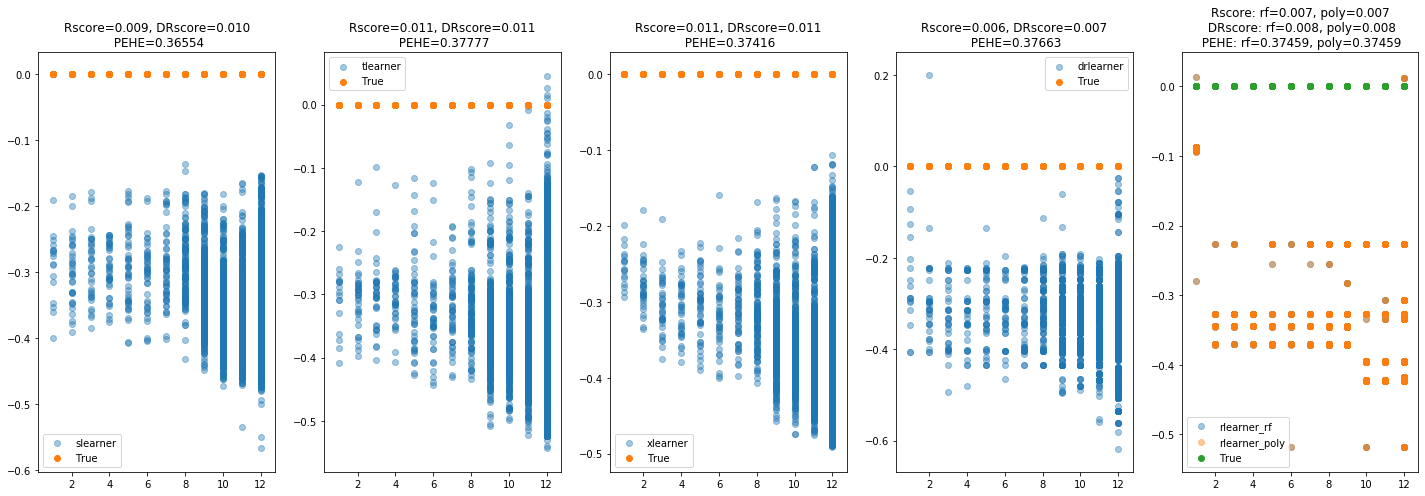

In [39]:
if plot:
    plt.figure(figsize=(20, 7))
    plt.subplot(1, 5, 1)
    plt.scatter(X[:, feat_ind], slearner_preds, label='slearner', alpha=.4)
    plt.scatter(X[:, feat_ind], moment_fn(X, true_f), label='True')
    plt.title(f'Rscore={slearner_rscore:.3f}, DRscore={slearner_drscore:.3f}\n '
              f'PEHE={pehe(moment_fn(X, true_f), slearner_preds):.5f}')
    plt.legend()
    plt.subplot(1, 5, 2)
    plt.scatter(X[:, feat_ind], tlearner_preds, label='tlearner', alpha=.4)
    plt.scatter(X[:, feat_ind], moment_fn(X, true_f), label='True')
    plt.title(f'Rscore={tlearner_rscore:.3f}, DRscore={tlearner_drscore:.3f}\n '
              f'PEHE={pehe(moment_fn(X, true_f), tlearner_preds):.5f}')
    plt.legend()
    plt.subplot(1, 5, 3)
    plt.scatter(X[:, feat_ind], xlearner_preds, label='xlearner', alpha=.4)
    plt.scatter(X[:, feat_ind], moment_fn(X, true_f), label='True')
    plt.title(f'Rscore={xlearner_rscore:.3f}, DRscore={xlearner_drscore:.3f}\n '
              f'PEHE={pehe(moment_fn(X, true_f), xlearner_preds):.5f}')
    plt.legend()
    plt.subplot(1, 5, 4)
    plt.scatter(X[:, feat_ind], drlearner_preds, label='drlearner', alpha=.4)
    plt.scatter(X[:, feat_ind], moment_fn(X, true_f), label='True')
    plt.title(f'Rscore={drlearner_rscore:.3f}, DRscore={drlearner_drscore:.3f}\n '
              f'PEHE={pehe(moment_fn(X, true_f), drlearner_preds):.5f}')
    plt.legend()
    plt.subplot(1, 5, 5)
    plt.scatter(X[:, feat_ind], rlearner_preds_rf, label='rlearner_rf', alpha=.4)
    plt.scatter(X[:, feat_ind], rlearner_preds_poly, label='rlearner_poly', alpha=.4)
    plt.scatter(X[:, feat_ind], moment_fn(X, true_f), label='True')
    plt.title(f'Rscore: rf={rlearner_rf_rscore:.3f}, poly={rlearner_poly_rscore:.3f}\n '
              f'DRscore: rf={rlearner_rf_drscore:.3f}, poly={rlearner_poly_drscore:.3f}\n '
              f'PEHE: rf={pehe(moment_fn(X, true_f), rlearner_preds_rf):.5f}, '
              f'poly={pehe(moment_fn(X, true_f), rlearner_preds_poly):.5f}')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Causal Model Selection and Ensembling

In [40]:
from sklearn.base import BaseEstimator

class Ensemble(BaseEstimator):
    
    def __init__(self, models, weights):
        self.models = models
        self.weights = weights
    
    def predict(self, X):
        return np.sum(self.weights.reshape((-1, 1)) * np.array([m.predict(X) for m in self.models]), axis=0)

In [41]:
models = [slearner, tlearner, xlearner, drlearner, rlearner_rf, rlearner_poly]
scores = np.array([slearner_rscore, tlearner_rscore, xlearner_rscore, drlearner_rscore,
                   rlearner_rf_rscore, rlearner_poly_rscore])

eta_grid = np.logspace(-3, 4, 5)
ens = {}
for eta in eta_grid:
    weights = scipy.special.softmax(eta * scores)
    ensemble = Ensemble(models, weights)
    ens[eta] = (ensemble, rscore(ensemble.predict(Xval[:, hetero_inds])))

rscore_best = -np.inf
for eta in eta_grid:
    if ens[eta][1] >= rscore_best:
        rscore_best = ens[eta][1]
        eta_best = eta

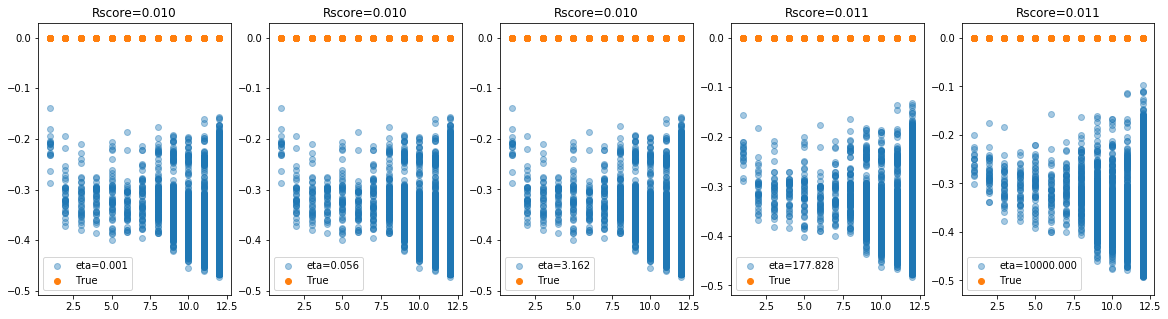

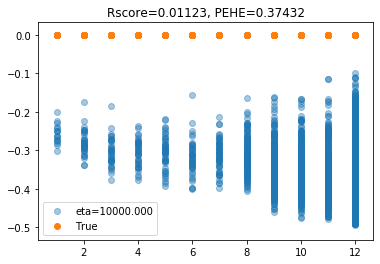

In [42]:
if plot:
    plt.figure(figsize=(20, 5))
    for it, eta in enumerate(eta_grid):
        plt.subplot(1, len(eta_grid), it + 1)
        plt.scatter(X[:, feat_ind], ens[eta][0].predict(X[:, hetero_inds]), label=f'eta={eta:.3f}', alpha=.4)
        plt.scatter(X[:, feat_ind], moment_fn(X, true_f), label='True')
        plt.title(f'Rscore={ens[eta][1]:.3f}')
        plt.legend()
    plt.show()

    plt.scatter(X[:, feat_ind], ens[eta_best][0].predict(X[:, hetero_inds]), label=f'eta={eta_best:.3f}', alpha=.4)
    plt.scatter(X[:, feat_ind], moment_fn(X, true_f), label='True')
    plt.title(f'Rscore={ens[eta_best][1]:.5f}, '
              f'PEHE={pehe(moment_fn(X, true_f), ens[eta_best][0].predict(X[:, hetero_inds])):.5f}')
    plt.legend()
    plt.show()

In [43]:
rscore_best = ens[eta_best]

In [44]:
models = [slearner, tlearner, xlearner, drlearner, rlearner_rf, rlearner_poly]
scores = np.array([slearner_drscore, tlearner_drscore, xlearner_drscore, drlearner_drscore,
                   rlearner_rf_drscore, rlearner_poly_drscore])

eta_grid = np.logspace(-3, 4, 5)
ens = {}
for eta in eta_grid:
    weights = scipy.special.softmax(eta * scores)
    ensemble = Ensemble(models, weights)
    ens[eta] = (ensemble, drscore(ensemble.predict(Xval[:, hetero_inds])))

drscore_best = -np.inf
for eta in eta_grid:
    if ens[eta][1] >= drscore_best:
        drscore_best = ens[eta][1]
        eta_best = eta

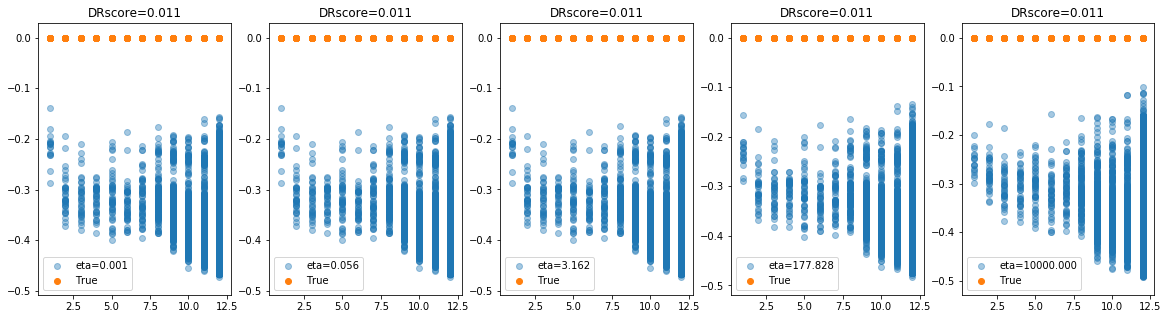

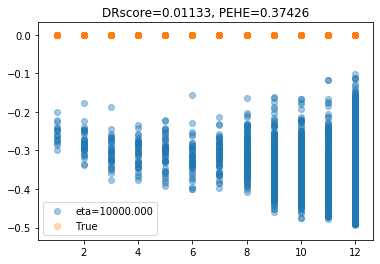

In [45]:
if plot:
    plt.figure(figsize=(20, 5))
    for it, eta in enumerate(eta_grid):
        plt.subplot(1, len(eta_grid), it + 1)
        plt.scatter(X[:, feat_ind], ens[eta][0].predict(X[:, hetero_inds]), label=f'eta={eta:.3f}', alpha=.4)
        plt.scatter(X[:, feat_ind], moment_fn(X, true_f), label='True')
        plt.title(f'DRscore={ens[eta][1]:.3f}')
        plt.legend()
    plt.show()

    plt.scatter(X[:, feat_ind], ens[eta_best][0].predict(X[:, hetero_inds]), label=f'eta={eta_best:.3f}', alpha=.4)
    plt.scatter(X[:, feat_ind], moment_fn(X, true_f), label='True', alpha=.3)
    plt.title(f'DRscore={ens[eta_best][1]:.5f}, '
              f'PEHE={pehe(moment_fn(X, true_f), ens[eta_best][0].predict(X[:, hetero_inds])):.5f}')
    plt.legend()
    plt.show()

In [46]:
drscore_best = ens[eta_best]

In [47]:
models = [slearner, tlearner, xlearner, drlearner, rlearner_rf, rlearner_poly]
scores = np.array([slearner_qscore, tlearner_qscore, xlearner_qscore, drlearner_qscore,
                   rlearner_rf_qscore, rlearner_poly_qscore])

eta_grid = np.logspace(-3, 4, 5)
ens = {}
for eta in eta_grid:
    weights = scipy.special.softmax(eta * scores)
    ensemble = Ensemble(models, weights)
    ens[eta] = (ensemble, qscore(ensemble.predict(Xval[:, hetero_inds])))

qscore_best = -np.inf
for eta in eta_grid:
    if ens[eta][1] >= qscore_best:
        qscore_best = ens[eta][1]
        eta_best = eta

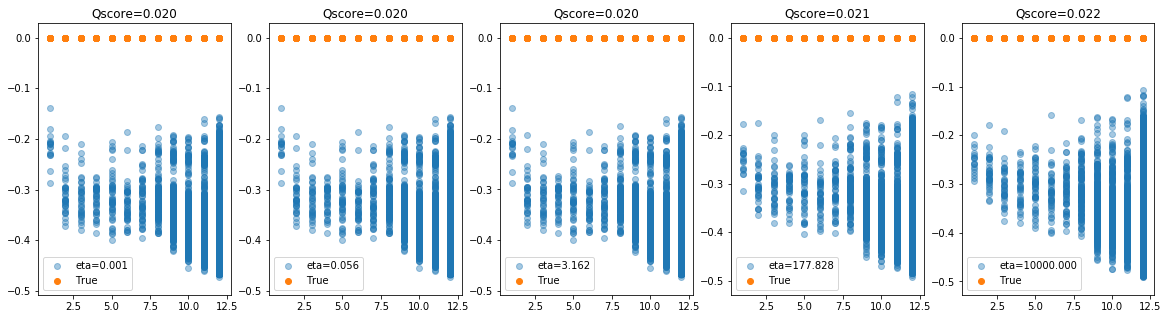

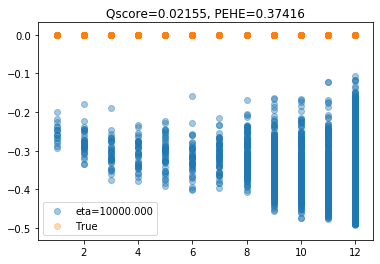

In [48]:
if plot:
    plt.figure(figsize=(20, 5))
    for it, eta in enumerate(eta_grid):
        plt.subplot(1, len(eta_grid), it + 1)
        plt.scatter(X[:, feat_ind], ens[eta][0].predict(X[:, hetero_inds]), label=f'eta={eta:.3f}', alpha=.4)
        plt.scatter(X[:, feat_ind], moment_fn(X, true_f), label='True')
        plt.title(f'Qscore={ens[eta][1]:.3f}')
        plt.legend()
    plt.show()

    plt.scatter(X[:, feat_ind], ens[eta_best][0].predict(X[:, hetero_inds]), label=f'eta={eta_best:.3f}', alpha=.4)
    plt.scatter(X[:, feat_ind], moment_fn(X, true_f), label='True', alpha=.3)
    plt.title(f'Qscore={ens[eta_best][1]:.5f}, '
              f'PEHE={pehe(moment_fn(X, true_f), ens[eta_best][0].predict(X[:, hetero_inds])):.5f}')
    plt.legend()
    plt.show()

In [49]:
qscore_best = ens[eta_best]

In [50]:
models = [slearner, tlearner, xlearner, drlearner, rlearner_rf, rlearner_poly]
scores = np.array([slearner_calscore, tlearner_calscore, xlearner_calscore, drlearner_calscore,
                   rlearner_rf_calscore, rlearner_poly_calscore])

eta_grid = np.logspace(-3, 4, 5)
ens = {}
for eta in eta_grid:
    weights = scipy.special.softmax(eta * scores)
    ensemble = Ensemble(models, weights)
    ens[eta] = (ensemble, calscore(ensemble.predict(Xval[:, hetero_inds]),
                                   ensemble.predict(X[:, hetero_inds])))

calscore_best = -np.inf
for eta in eta_grid:
    if ens[eta][1] >= calscore_best:
        calscore_best = ens[eta][1]
        eta_best = eta

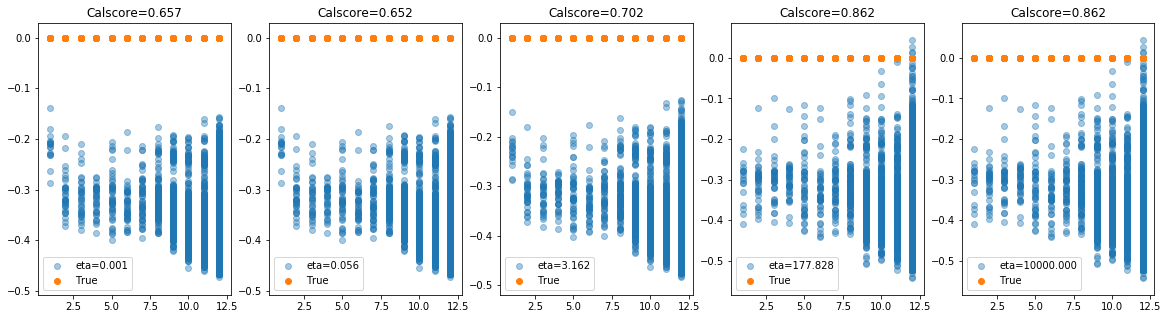

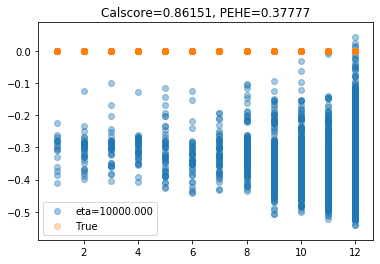

In [51]:
if plot:
    plt.figure(figsize=(20, 5))
    for it, eta in enumerate(eta_grid):
        plt.subplot(1, len(eta_grid), it + 1)
        plt.scatter(X[:, feat_ind], ens[eta][0].predict(X[:, hetero_inds]), label=f'eta={eta:.3f}', alpha=.4)
        plt.scatter(X[:, feat_ind], moment_fn(X, true_f), label='True')
        plt.title(f'Calscore={ens[eta][1]:.3f}')
        plt.legend()
    plt.show()

    plt.scatter(X[:, feat_ind], ens[eta_best][0].predict(X[:, hetero_inds]), label=f'eta={eta_best:.3f}', alpha=.4)
    plt.scatter(X[:, feat_ind], moment_fn(X, true_f), label='True', alpha=.3)
    plt.title(f'Calscore={ens[eta_best][1]:.5f}, '
              f'PEHE={pehe(moment_fn(X, true_f), ens[eta_best][0].predict(X[:, hetero_inds])):.5f}')
    plt.legend()
    plt.show()

In [52]:
calscore_best = ens[eta_best]

In [53]:
overall_best = Ensemble([rscore_best[0], drscore_best[0], qscore_best[0], calscore_best[0]],
                        np.array([.25, .25, .25, .25]))

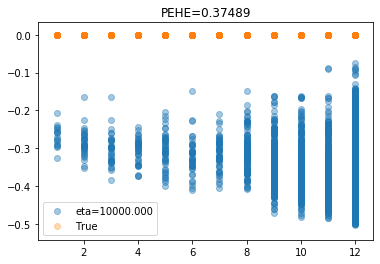

In [54]:
plt.scatter(X[:, feat_ind], overall_best.predict(X[:, hetero_inds]), label=f'eta={eta_best:.3f}', alpha=.4)
plt.scatter(X[:, feat_ind], moment_fn(X, true_f), label='True', alpha=.3)
plt.title(f'PEHE={pehe(moment_fn(X, true_f), overall_best.predict(X[:, hetero_inds])):.5f}')
plt.legend()
plt.show()

In [55]:
# joblib.dump(overall_best, 'ensemble_cate.jbl')

In [56]:
# overall_best = joblib.load('ensemble_cate.jbl')[0]

# Interpretation of Learned Model

In [58]:
# explainer = shap.KernelExplainer(overall_best.predict, X[np.random.choice(X.shape[0], 100)][:, hetero_inds])
# shap_values = explainer.shap_values(Xval[:100, hetero_inds], nsamples=100)

In [59]:
# shap.summary_plot(shap_values, feature_names=np.array(column_names)[hetero_inds])

# Validation Based on Calibration

In [60]:
splits_test = list(StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=123).split(Xtest, Xtest[:, 0]))

n = Xtest.shape[0]
reg_preds_test = np.zeros(n)
reg_one_preds_test = np.zeros(n)
reg_zero_preds_test = np.zeros(n)

for train, test in splits_test:
    reg_test = model_reg().fit(Xtest[train], ytest[train])
    reg_preds_test[test] = reg_test.predict(Xtest[test])
    reg_one_preds_test[test] = reg_test.predict(np.hstack([np.ones((len(test), 1)), Xtest[test, 1:]]))
    reg_zero_preds_test[test] = reg_test.predict(np.hstack([np.zeros((len(test), 1)), Xtest[test, 1:]]))

prop_preds_test = cross_val_predict(model_t(), Xtest[:, 1:], Xtest[:, 0], cv=splits_test)
res_preds_test = cross_val_predict(model_y(), Xtest[:, 1:], ytest, cv=splits_test)
yres_test = ytest - res_preds_test
tres_test = Xtest[:, 0] - prop_preds_test

In [61]:
dr_test = reg_one_preds_test - reg_zero_preds_test
reisz_test = (Xtest[:, 0] - prop_preds_test) / np.clip(prop_preds_test * (1 - prop_preds_test), .09, np.inf)
dr_test += (ytest - reg_preds_test) * reisz_test

In [62]:
cate_test = overall_best.predict(Xtest[:, hetero_inds])

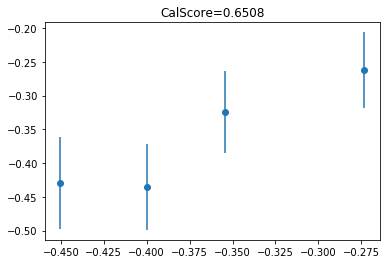

In [63]:
qs = np.percentile(cate_test, np.arange(0, 101, 25))

ate = np.zeros((len(qs) - 1, 3))
predicted_ate = np.zeros(len(qs) - 1)
for it in range(len(qs) - 1):
    inds = (qs[it] <= cate_test) & (cate_test < qs[it + 1])
    ate[it, :] = (np.mean(dr_test[inds]), np.std(dr_test[inds])/np.sqrt(np.sum(inds)), np.mean(inds))
    predicted_ate[it] = np.mean(cate_test[inds])

cal = np.sum(ate[:, 2] * np.abs(ate[:, 0] - predicted_ate))
calbase = np.sum(ate[:, 2] * np.abs(ate[:, 0] - np.mean(dr_test)))
calscore = 1 - cal/calbase
plt.title(f'CalScore={calscore:.4f}')
plt.errorbar(predicted_ate, ate[:, 0], yerr=1.96*ate[:, 1], fmt='o')
plt.show()

# Validation Based on Uplift Curves

#### Uniform Confidence Band with Multiplier Bootstrap

3.4036819543365278


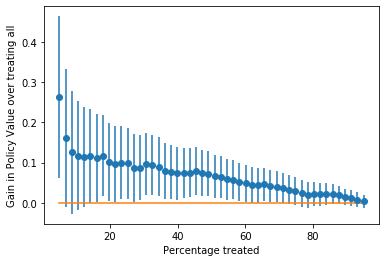

Heterogeneity Statistic: 0.06115593454422866


In [64]:
# Based on out-of-sample CATE thresholds
ugrid = np.linspace(5, 95, 50)
qs = np.percentile(overall_best.predict(Xval[:, hetero_inds]), ugrid)

ate = np.zeros((len(qs), 3))
true_ate = np.zeros(len(qs))
psi = np.zeros((len(qs), dr_test.shape[0]))
n = len(dr_test)
all_ate = np.mean(dr_test)
for it in range(len(qs)):
    inds = (qs[it] <= cate_test)
    prob = np.sum(inds) / n
    pate = np.mean(dr_test * inds / prob)
    psi[it, :] = (dr_test - all_ate) * (inds / prob - 1)
    ate[it, 0] = np.mean(psi[it])
    psi[it, :] -= ate[it, 0]
    ate[it, 1] = np.sqrt(np.mean(psi[it]**2) / n)
    ate[it, 2] = prob
    if semi_synth:
        true_cate = moment_fn(Xtest, true_f)
        true_ate[it] = np.mean((true_cate - np.mean(true_cate)) * (inds * n / np.sum(inds) - 1))

if dr_test.shape[0] > 1e6:
    mboot = np.zeros((len(qs), 1000))
    for it in range(1000):
        w = np.random.normal(0, 1, size=(dr_test.shape[0],))
        mboot[:, it] = (psi / ate[:, [1]]) @ w / n
else:
    w = np.random.normal(0, 1, size=(dr_test.shape[0], 1000))
    mboot = (psi / ate[:, [1]]) @ w / n
max_mboot = np.max(np.abs(mboot), axis=0)
max_percentile = np.percentile(max_mboot, 99)
print(max_percentile)
plt.errorbar(100 - ugrid, ate[:, 0], yerr=max_percentile*ate[:, 1], fmt='o')
plt.plot(100 - ugrid, np.zeros(len(ugrid)))
if semi_synth:
    plt.plot(100 - ugrid, true_ate, 'o')
plt.xlabel("Percentage treated")
plt.ylabel("Gain in Policy Value over treating all")
plt.show()
print(f'Heterogeneity Statistic: {np.max(ate[:, 0] - max_percentile*ate[:, 1])}')

In [65]:
autoc_psi = np.sum(psi[:-1] * np.diff(ugrid).reshape(-1, 1) / 100, 0)
autoc = np.sum(ate[:-1, 0] * np.diff(ugrid) / 100)
autoc_stderr = np.sqrt(np.mean(autoc_psi**2) / n)
print(autoc, autoc_stderr, 2.58 * autoc_stderr)

0.058193009499855015 0.01229819604099423 0.03172934578576511


3.4706736925129027


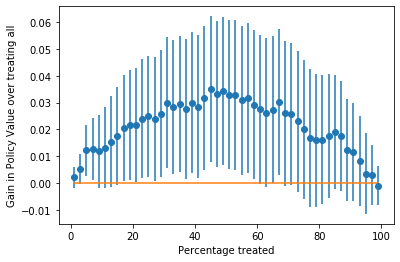

Heterogeneity Statistic: 0.007880368804650185


In [66]:
# Based on out-of-sample CATE thresholds
ugrid = np.linspace(1, 99, 50)
qs = np.percentile(overall_best.predict(Xval[:, hetero_inds]), ugrid)

ate = np.zeros((len(qs), 3))
true_ate = np.zeros(len(qs))
psi = np.zeros((len(qs), dr_test.shape[0]))
n = len(dr_test)
all_ate = np.mean(dr_test)
for it in range(len(qs)):
    inds = (qs[it] <= cate_test)
    prob = np.mean(inds)
    psi[it, :] = (dr_test - all_ate) * (inds - prob)
    ate[it, 0] = np.mean(psi[it])
    psi[it, :] -= ate[it, 0]
    ate[it, 1] = np.sqrt(np.mean(psi[it]**2) / n)
    ate[it, 2] = prob
    if semi_synth:
        true_cate = moment_fn(Xtest, true_f)
        true_ate[it] = np.mean((true_cate - np.mean(true_cate)) * (inds - prob))

if dr_test.shape[0] > 1e6:
    mboot = np.zeros((len(qs), 1000))
    for it in range(1000):
        w = np.random.normal(0, 1, size=(dr_test.shape[0],))
        mboot[:, it] = (psi / ate[:, [1]]) @ w / n
else:
    w = np.random.normal(0, 1, size=(dr_test.shape[0], 10000))
    mboot = (psi / ate[:, [1]]) @ w / n
max_mboot = np.max(np.abs(mboot), axis=0)
max_percentile = np.percentile(max_mboot, 99)
print(max_percentile)
plt.errorbar(100 - ugrid, ate[:, 0], yerr=max_percentile*ate[:, 1], fmt='o')
plt.plot(100 - ugrid, np.zeros(len(ugrid)))
if semi_synth:
    plt.plot(100 - ugrid, true_ate, 'o')
plt.xlabel("Percentage treated")
plt.ylabel("Gain in Policy Value over treating all")
plt.show()
print(f'Heterogeneity Statistic: {np.max(ate[:, 0] - max_percentile*ate[:, 1])}')

In [67]:
qini_psi = np.sum(psi[:-1] * np.diff(ugrid).reshape(-1, 1) / 100, 0)
qini = np.sum(ate[:-1, 0] * np.diff(ugrid) / 100)
qini_stderr = np.sqrt(np.mean(qini_psi**2) / n)
print(qini, qini_stderr, 2.58 * qini_stderr)

0.021291929805116717 0.00464923895456892 0.011995036502787815


### Using In-Sample Quantiles (RATE)

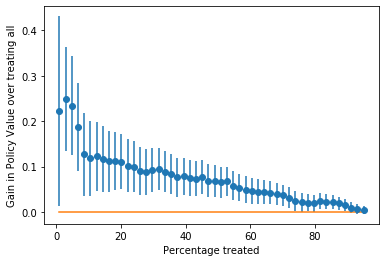

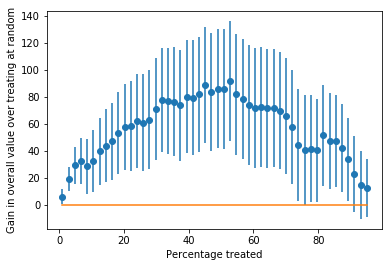

In [68]:
# Based on within sample CATE order. Rank Average Effect. Breaking ties at random
ugrid = np.linspace(5, 99, 50)
qs = np.percentile(cate_test, ugrid)

ate = np.zeros((len(qs), 3))
n = len(dr_test)
for it in range(len(qs)):
    inds = (qs[it] < cate_test)
    inds_tie = np.argwhere(qs[it] == cate_test)[:, 0]
    if np.sum(inds_tie) > 0:
        inds_tie = np.random.choice(inds_tie, int(np.floor((100 - ugrid[it])*n/100 - np.sum(inds))), replace=False)
    inds[inds_tie] = True
    ate[it, :] = (np.mean(dr_test * inds * n / np.sum(inds) - dr_test),
                  np.std(dr_test * inds * n / np.sum(inds) - dr_test) / np.sqrt(n),
                  np.sum(inds))

plt.errorbar(100 - ugrid, ate[:, 0], yerr=1.96*ate[:, 1], fmt='o')
plt.plot(100 - ugrid, np.zeros(len(ugrid)))
plt.xlabel("Percentage treated")
plt.ylabel("Gain in Policy Value over treating all")
plt.show()

qini = ate[:, 2] * ate[:, 0]
plt.errorbar(100 - ugrid, qini,
             yerr=1.96 * ate[:, 1]* ate[:, 2], fmt='o')
plt.plot(100 - ugrid, np.zeros(len(ugrid)))
plt.xlabel("Percentage treated")
plt.ylabel("Gain in overall value over treating at random")
plt.show()

In [69]:
from sklift.metrics import uplift_at_k, uplift_auc_score, qini_auc_score, weighted_average_uplift
from sklift.viz import plot_uplift_preds

def get_metrics(y_val, uplift_effect, treatment_val):
    no_effect_share = round(100 * np.sum(uplift_effect == 0) / len(uplift_effect), 2)
    positive_effect_share = round(100 * np.sum(uplift_effect > 0) / len(uplift_effect), 2)
    negative_effect_share = round(100 * np.sum(uplift_effect < 0) / len(uplift_effect), 2)
    print(f'Model predicts positive effect in visit probability after treatment for {positive_effect_share}% of cases.')
    print(f'Model predicts negative effect in visit probability after treatment for {negative_effect_share}% of cases.')
    print(f'Model predicts no effect in visit probability after treatment for {no_effect_share}% of cases.')

    upliftk = uplift_at_k(
        y_true = y_val, 
        uplift = uplift_effect, 
        treatment = treatment_val, 
        strategy='by_group', 
        k = 0.3
    )
    
    upliftk_all = uplift_at_k(
        y_true = y_val, 
        uplift = uplift_effect, 
        treatment = treatment_val, 
        strategy = 'overall',
    )

    qini_coef = qini_auc_score(
        y_true = y_val, 
        uplift = uplift_effect,
        treatment = treatment_val
    )

    uplift_auc = uplift_auc_score(
        y_true = y_val, 
        uplift = uplift_effect,
        treatment = treatment_val
    )
    wau = weighted_average_uplift(y_true = y_val, uplift = uplift_effect,
                                  treatment = treatment_val, strategy = 'by_group')
    wau_all = weighted_average_uplift(y_true = y_val, uplift = uplift_effect,
                                  treatment = treatment_val, strategy = 'overall')

    print(f'uplift at top 30% by group: {upliftk:.3f} by overall: {upliftk_all:.3f}\n',
          f'Weighted average uplift by group: {wau:.3f} by overall: {wau_all:.3f}\n',
          f'AUUC by group: {uplift_auc:.3f}\n',
          f'AUQC by group: {qini_coef:.3f}\n')

Model predicts positive effect in visit probability after treatment for 0.0% of cases.
Model predicts negative effect in visit probability after treatment for 100.0% of cases.
Model predicts no effect in visit probability after treatment for 0.0% of cases.
uplift at top 30% by group: -0.265 by overall: -0.266
 Weighted average uplift by group: -0.363 by overall: -0.358
 AUUC by group: 0.077
 AUQC by group: 0.089



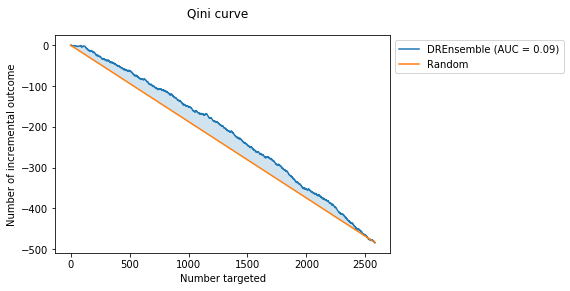

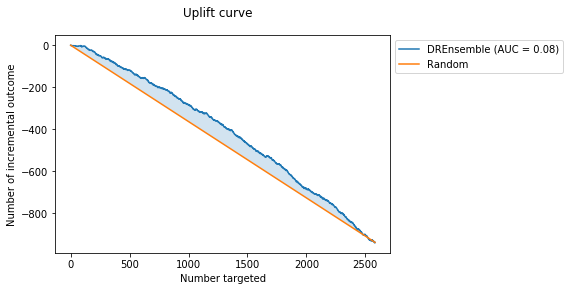

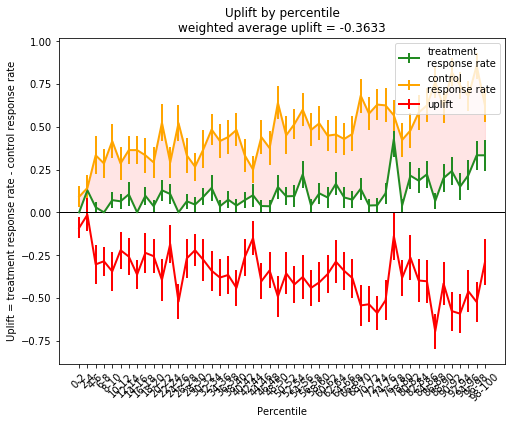

In [70]:
from sklift.viz import plot_qini_curve, plot_uplift_curve, plot_uplift_by_percentile

if abtest:
    get_metrics(ytest, cate_test, Xtest[:, 0])

    qini_disp = plot_qini_curve(
        ytest, cate_test, Xtest[:, 0],
        perfect=False, name='DREnsemble'
    );

    qini_disp.figure_.suptitle("Qini curve");
    
    uplift_disp = plot_uplift_curve(
        ytest, cate_test, Xtest[:, 0],
        perfect=False, name='DREnsemble'
    );

    uplift_disp.figure_.suptitle("Uplift curve");
    
    
    plot_uplift_by_percentile(ytest, cate_test, Xtest[:, 0], strategy='overall',
                          kind='line', bins=50, string_percentiles=True)

# Validation based on p-value of linear heterogeneity model in PLR

In [71]:
OLS(yres_test, np.stack((np.ones(len(tres_test)), tres_test,
                        (cate_test - np.mean(cate_test)) * tres_test), axis=-1)).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.173
Model:                            OLS   Adj. R-squared:                  0.172
Method:                 Least Squares   F-statistic:                     269.2
Date:                Fri, 30 Dec 2022   Prob (F-statistic):          6.81e-107
Time:                        13:23:11   Log-Likelihood:                -1320.4
No. Observations:                2582   AIC:                             2647.
Df Residuals:                    2579   BIC:                             2664.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0029      0.008      0.363      0.717      -0.013       0.018
x1            -0.3608      0.016    -22.695      0.000      -0.392      -0.330
x2             1.0762      0.224      4.808      0.000       0.637       1.515
==============================================================================
Omnibus:                      185.038   Durbin-Watson:                   1.937
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              183.177
Skew:                           0.601   Prob(JB):                     1.67e-40
Kurtosis:                       2.492   Cond. No.                         28.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Validation based on p-value of DR out of sample

In [72]:
OLS(dr_test, np.stack((np.ones(len(tres_test)), cate_test - np.mean(cate_test)), axis=-1)).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     21.55
Date:                Fri, 30 Dec 2022   Prob (F-statistic):           3.62e-06
Time:                        13:23:12   Log-Likelihood:                -3119.6
No. Observations:                2582   AIC:                             6243.
Df Residuals:                    2580   BIC:                             6255.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.3632      0.016    -22.778      0.000      -0.395      -0.332
x1             1.0417      0.224      4.642      0.000       0.602       1.482
==============================================================================
Omnibus:                      121.870   Durbin-Watson:                   1.941
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              102.623
Skew:                           0.415   Prob(JB):                     5.20e-23
Kurtosis:                       2.484   Cond. No.                         14.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [73]:
# hypothetical ideal validation for semi-synthetic data

OLS(moment_fn(Xtest, true_f),
    np.stack((np.ones(len(tres_test)), cate_test - np.mean(cate_test)), axis=-1)).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                         nan
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Fri, 30 Dec 2022   Prob (F-statistic):                nan
Time:                        13:23:12   Log-Likelihood:                    inf
No. Observations:                2582   AIC:                              -inf
Df Residuals:                    2580   BIC:                              -inf
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const               0          0        nan        nan           0           0
x1                  0          0        nan        nan           0           0
==============================================================================
Omnibus:                     6625.916   Durbin-Watson:                     nan
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              968.250
Skew:                           0.000   Prob(JB):                    5.59e-211
Kurtosis:                       0.000   Cond. No.                         14.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Confidence Intervals with the DRLearner

In [74]:
from statsmodels.api import OLS
Xpoly = PolynomialFeatures(degree=1, include_bias=True).fit_transform(X[:, hetero_inds])
lr = OLS(dr_preds, Xpoly).fit()
pred_df = lr.get_prediction(Xpoly).summary_frame(alpha=.01)

No handles with labels found to put in legend.


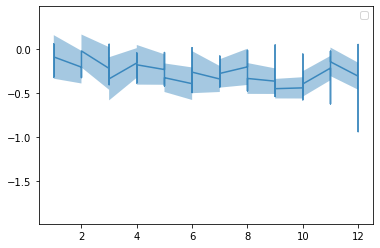

In [75]:
inds = np.argsort(X[:, feat_ind])
plt.fill_between(X[inds, feat_ind], pred_df['mean_ci_lower'][inds], pred_df['mean_ci_upper'][inds], alpha=.4)
plt.plot(X[inds, feat_ind], pred_df['mean'][inds], alpha=.8)
plt.legend()
plt.show()

No handles with labels found to put in legend.


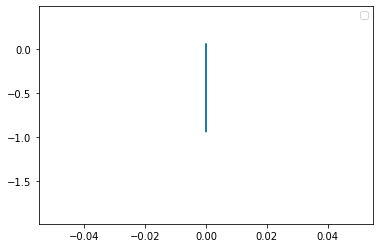

In [76]:
inds = np.argsort(X[:, feat_ind])
true_proj = LinearRegression().fit(Xpoly, moment_fn(X, true_f)).predict(Xpoly)
inds = np.argsort(true_proj)
plt.plot(true_proj[inds], pred_df['mean'][inds])
plt.fill_between(true_proj[inds], pred_df['mean_ci_lower'][inds], pred_df['mean_ci_upper'][inds], alpha=.4)
plt.plot(np.linspace(np.min(true_proj), np.max(true_proj), 100),
         np.linspace(np.min(true_proj), np.max(true_proj), 100))
plt.legend()
plt.show()

In [77]:
from statsmodels.formula.api import ols
df = pd.DataFrame(X[:, hetero_inds], columns=np.array(column_names)[hetero_inds])
df['dr'] = dr_preds
lr = ols('dr ~ C(polviews)', df).fit()
lr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     dr   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     7.646
Date:                Fri, 30 Dec 2022   Prob (F-statistic):           3.32e-08
Time:                        13:23:15   Log-Likelihood:                -9348.2
No. Observations:                7744   AIC:                         1.871e+04
Df Residuals:                    7737   BIC:                         1.876e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -0.2209      0.055     -3.983      0.000      -0.330      -0.112
C(polviews)[T.2.0]    -0.0594      0.061     -0.970      0.332      -0.179       0.061
C(polviews)[T.3.0]    -0.0668      0.061     -1.098      0.272      -0.186       0.052
C(polviews)[T.4.0]    -0.1556      0.058     -2.706      0.007      -0.268      -0.043
C(polviews)[T.5.0]    -0.2078      0.060     -3.478      0.001      -0.325      -0.091
C(polviews)[T.6.0]    -0.2146      0.060     -3.548      0.000      -0.333      -0.096
C(polviews)[T.7.0]    -0.2143      0.079     -2.725      0.006      -0.368      -0.060
==============================================================================
Omnibus:                      514.257   Durbin-Watson:                   2.005
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              375.545
Skew:                           0.439   Prob(JB):                     2.83e-82
Kurtosis:                       2.373   Cond. No.                         18.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [78]:
pred_df = lr.get_prediction(df).summary_frame(alpha=.01)

No handles with labels found to put in legend.


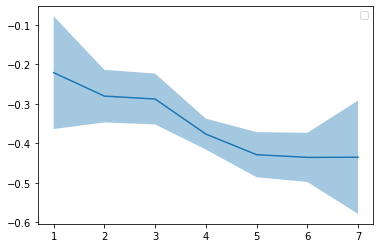

In [79]:
inds = np.argsort(df['polviews']) #X[:, feat_ind])
plt.plot(df['polviews'].iloc[inds], pred_df['mean'][inds])
plt.fill_between(df['polviews'].iloc[inds], pred_df['mean_ci_lower'][inds], pred_df['mean_ci_upper'][inds], alpha=.4)
plt.legend()
plt.show()

In [ ]:
true_proj = LinearRegression().fit(np.log(df[['inc']]), moment_fn(X, true_f)).predict(np.log(df[['inc']]))
inds = np.argsort(true_proj)
plt.plot(true_proj[inds], pred_df['mean'][inds])
plt.fill_between(true_proj[inds], pred_df['mean_ci_lower'][inds], pred_df['mean_ci_upper'][inds], alpha=.4)
plt.plot(np.linspace(np.min(true_proj), np.max(true_proj), 100),
         np.linspace(np.min(true_proj), np.max(true_proj), 100))
plt.legend()
plt.show()

# Non-Parametric Confidence Intervals with Causal Forests

In [ ]:
from econml.grf import CausalForest

est = CausalForest(4000, max_depth=5, max_samples=.4, min_samples_leaf=50, min_weight_fraction_leaf=.0)
est.fit(X[:, hetero_inds], tres, yres)

In [ ]:
top_feat = hetero_inds[np.argsort(est.feature_importances_)[-1]]
print(column_names[top_feat])

In [ ]:
inds = np.argsort(df['polviews']) #X[:, feat_ind])
preds, lb, ub = est.predict(X[:, hetero_inds], interval=True, alpha=.01)
plt.plot(df['polviews'].iloc[inds], preds[inds])
plt.fill_between(df['polviews'].iloc[inds], lb[inds].flatten(), ub[inds].flatten(), alpha=.4)
plt.legend()
plt.show()

In [ ]:
true_proj = moment_fn(X, true_f)
inds = np.argsort(true_proj)
plt.plot(true_proj[inds], preds[inds])
plt.fill_between(true_proj[inds], lb[inds].flatten(), ub[inds].flatten(), alpha=.4)
plt.plot(np.linspace(np.min(true_proj), np.max(true_proj), 100),
         np.linspace(np.min(true_proj), np.max(true_proj), 100))
plt.legend()
plt.show()

In [ ]:
from econml.dml import CausalForestDML

est = CausalForestDML(model_y=model_y(), model_t=model_t(),
                      n_estimators=4000, cv=5)

In [ ]:
est.tune(y, X[:, 0], X=X[:, 1:])

In [ ]:
est.fit(y, X[:, 0], X=X[:, 1:])

In [ ]:
df = pd.DataFrame(X[:, 1:], columns=np.array(column_names)[1:])
grid = np.unique(np.percentile(df['polviews'], np.arange(0, 110, 20)))
dfpd = pd.DataFrame(np.tile(np.median(df, axis=0, keepdims=True), (len(grid), 1)),
                    columns=df.columns)
dfpd['polviews'] = grid

In [ ]:
inf = est.effect_inference(dfpd)
preds, lb, ub = inf.pred, *inf.conf_int(alpha=0.01)
plt.errorbar(dfpd['polviews'], preds, yerr=(preds-lb, ub-preds))
plt.legend()
plt.show()

# Non-Parametric Confidence Intervals with Doubly Robust Forests

In [ ]:
from econml.grf import RegressionForest

est = RegressionForest(4000, max_depth=5, max_samples=.4, min_samples_leaf=50,
                       min_weight_fraction_leaf=.0, n_jobs=1, verbose=3)
est.fit(X[:, hetero_inds], dr_preds)

In [ ]:
top_feat = hetero_inds[np.argsort(est.feature_importances_)[-1]]
print(column_names[top_feat])

In [ ]:
df = pd.DataFrame(X[:, 1:], columns=np.array(column_names)[1:])
grid = np.unique(np.percentile(df[column_names[top_feat]], np.arange(0, 110, 20)))
dfpd = pd.DataFrame(np.tile(np.median(df, axis=0, keepdims=True), (len(grid), 1)),
                    columns=df.columns)
dfpd['polviews'] = grid

preds, lb, ub = est.predict(dfpd, interval=True, alpha=.01)
plt.errorbar(dfpd['polviews'], preds, yerr=(preds-lb, ub-preds), alpha=.4)
plt.legend()
plt.show()

In [ ]:
true_proj = moment_fn(Xs, true_f)
inds = np.argsort(true_proj)
plt.plot(true_proj[inds], preds[inds])
plt.fill_between(true_proj[inds], lb[inds].flatten(), ub[inds].flatten(), alpha=.4)
plt.plot(np.linspace(np.min(true_proj), np.max(true_proj), 100),
         np.linspace(np.min(true_proj), np.max(true_proj), 100))
plt.legend()
plt.show()